# Extracting Morphological Features of Neurons

*author: Ciara D. Janer*

*date: 07/20/2022*


This exercise is obtained from the tutorial session from the [Simulation Neuroscience MOOC by EPFL](https://learning.edx.org/course/course-v1:EPFLx+SimNeuroX+3T2021/home). 

We use [Blue Brain Nexus](https://www.epfl.ch/research/domains/bluebrain/wp-content/uploads/2021/01/Blue_Brain_Nexus_2021-web.pdf) from the Blue Brain Project which is a data and knowledge graph platform. To learn more about the platform and the sandbox to try the software visit [Nexus Fusion](https://bluebrainnexus.io/products/nexus-fusion/). 

In this exercise we use Nexus to manipulate and analyze data from the Allen Institute Database. Particularly, we use neuronal cell data from the [Allen Cell Types Database](https://celltypes.brain-map.org/) which can be accessed via  [AllenSDK](https://allensdk.readthedocs.io/en/latest/). We also use [neurom](https://github.com/BlueBrain/NeuroM) an open source python package that can be used to extract the neuron data.  

##Initialize and configure

In this project:

1. Obtain the data from a Blue Brain Nexus project where the neuron morphology is downloaded and saved (see instructions below)
2. Prepare the metadata 
3. Obtain and analyze morphological data
4. Perform statistical analysis on one neuron
5. Compare two neurons via the statistical properties of their morphologies 


### Prerequisites

This project uses the dataset made of mouse neuron morphologies downloaded from Allen Cell Types Database and MouseLight. We pull the data from a Blue Brain Nexus Project configured below. The notebook `Tutorial: Integrate Neuroscience Datasets from Multiple Sources using MINDS` [notebook](https://github.com/BlueBrain/nexus/blob/master/docs/src/main/paradox/docs/getting-started/notebooks/dataset_from_different_sources.ipynb) must be run prior to running this notebook.


In [1]:
!pip install pyRDF2vec
!pip install nexusforge==0.7.0
!pip install matplotlib
!pip install validators
!pip install gensim
!pip install sklearn
!pip install --upgrade nest-asyncio==1.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
###Imports

In [3]:
import getpass
import json
import requests
import time

import numpy as np
import pandas as pd

from community import community_louvain

from pathlib import Path

from kgforge.core import KnowledgeGraphForge

import nexussdk as nexus

from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG
from pyrdf2vec.graphs.vertex import Vertex
from pyrdf2vec.walkers import WLWalker
from pyrdf2vec.samplers import ObjFreqSampler

from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

from urllib.parse import quote_plus

In [4]:
matplotlib inline

## Select a Blue Brain Nexus project from which to obtain neuron morphology 

### Authentication

- Step 1: From the [web page](https://sandbox.bluebrainnexus.io), click on the login button in the top right corner and follow the instructions on screen.

- Step 2: You will then see a `Copy token` button in the top right corner. Click on it to copy the token to the clipboard.

Once a token is obtained, proceed to paste it as the value of the `TOKEN` variable below.

In [5]:
TOKEN = getpass.getpass()

··········


### Configure a forge client to store, manage and access datasets

In [6]:
r = requests.get('https://raw.githubusercontent.com/BlueBrain/nexus/ef830192d4e7bb95f9351c4bdab7b0114c27e2f0/docs/src/main/paradox/docs/getting-started/notebooks/rdfmodel/jsonldcontext.json')
dirpath = './rdfmodel'
Path(dirpath).mkdir(parents=True, exist_ok=True)
with open(f'{dirpath}/jsonldcontext.json', 'w') as outfile:
    json.dump(r.json(), outfile)

In [7]:
ENDPOINT = "https://sandbox.bluebrainnexus.io/v1"
ORG = "github-users"
PROJECT = "cdjcodes"  # Provide here the automatically created project name created when you logged into the Nexus sandbox instance.

In [8]:
forge = KnowledgeGraphForge("https://raw.githubusercontent.com/BlueBrain/nexus/ef830192d4e7bb95f9351c4bdab7b0114c27e2f0/docs/src/main/paradox/docs/getting-started/notebooks/forge.yml",
                            bucket=f"{ORG}/{PROJECT}",
                            endpoint=ENDPOINT,
                            token=TOKEN)

## Preparing the Data

###Selecting Neurons and Morphology Data from the Blue Brain Nexus

In [62]:
_type = "NeuronMorphology"

filters = {"type": _type}

number_of_results = 50 #change this to the desired number of neurons

morphologies = forge.search(filters, limit=number_of_results)

print(f"{str(len(morphologies))} dataset(s) of type {_type} found")

#Display as dataframes

morphologies_df = forge.as_dataframe(morphologies)
morphologies_df.head()

41 dataset(s) of type NeuronMorphology found


,id,type,_schemaProject,apicalDendrite,brainLocation.type,brainLocation.brainRegion.id,brainLocation.brainRegion.label,brainLocation.coordinatesInBrainAtlas.valueX,brainLocation.coordinatesInBrainAtlas.valueY,brainLocation.coordinatesInBrainAtlas.valueZ,...,donor__race,donor__years_of_seizure_history,subject.age.unitCode,subject.age.value,subject.sex.label,dateCreated,fluorophore,subject.species.id,version,virus
0,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",https://sandbox.bluebrainnexus.io/v1/projects/...,spiny,BrainLocation,http://api.brain-map.org/api/v2/data/Structure...,VISp5,8881.000000,953.839501,7768.226958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",https://sandbox.bluebrainnexus.io/v1/projects/...,spiny,BrainLocation,http://api.brain-map.org/api/v2/data/Structure...,VISpl4,9918.748413,2116.916014,2202.771870,...,,,,,,NaN,NaN,NaN,NaN,NaN
2,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",https://sandbox.bluebrainnexus.io/v1/projects/...,spiny,BrainLocation,http://api.brain-map.org/api/v2/data/Structure...,VISp5,8881.000000,953.839501,7768.226958,...,,,,,,NaN,NaN,NaN,NaN,NaN
3,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",https://sandbox.bluebrainnexus.io/v1/projects/...,spiny,BrainLocation,http://api.brain-map.org/api/v2/data/Structure...,VISp4,8190.000000,965.345564,8156.980882,...,,,,,,NaN,NaN,NaN,NaN,NaN
4,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",https://sandbox.bluebrainnexus.io/v1/projects/...,aspiny,BrainLocation,http://api.brain-map.org/api/v2/data/Structure...,VISp5,8976.635021,1295.513315,8057.360864,...,,,,,,NaN,NaN,NaN,NaN,NaN


In [10]:
dirpath = "./downloaded/"
forge.download(morphologies, "distribution.contentUrl", dirpath)

In [11]:
ls ./downloaded/

reconstruction.swc  reconstruction.swc.20220722072751


### Choose 1 Neuron to Display the Neuron Morphology Characteristics

> Indented block



Steps:
1. Install and import neurom
2. Use neurom to obtain the following morphologic characteristics:

  **Global**
  - Total length
  - Total area
  - Total volume
  - Number of bifurcations
  - Number of terminations

  **Sectional (Local)**
  - Length
  - Area
  - Volume
  - Angles (local and remote)
  - Branch Order
  - Totuosity
  - Assymmetry

In [12]:
#Install neurom
!pip install neurom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
#Import neurom
import neurom as nm

In [14]:
neuron = nm.load_morphology(f"{dirpath}/{morphologies[9].distribution.name}")

In [15]:
neuron

Morphology <soma: SomaSinglePoint(array([[416.4583, 333.0401,  25.8964,   6.5677]], dtype=float32)) <center: [416.4583 333.0401  25.8964], radius: 6.5677>, n_neurites: 30>

### Visualize neuron : 2d, 3d and dendogram 

After loading the neuron information, we can first visualize the cell in different ways. 

In [16]:
from neurom.viewer import draw

In [ ]:
draw?

This function draws a morphology object and takes the **neuron morphology object** which can either be classified as a neuron, tree or soma and takes the mode of display (2d, 3d, dendogram).   


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'reconstruction.swc'}, xlabel='x', ylabel='y'>)

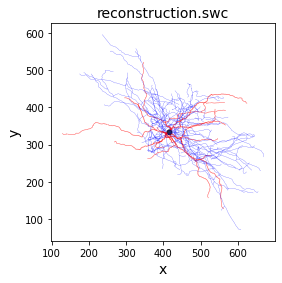

In [17]:
# Display 2D neuron
draw(neuron)

(<Figure size 432x288 with 1 Axes>,
 <Axes3DSubplot:title={'center':'reconstruction.swc'}, xlabel='X', ylabel='Y'>)

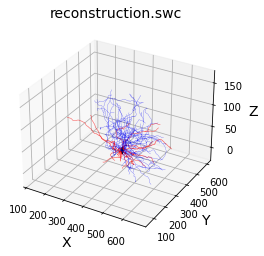

In [18]:
#Display neuron in 3D
draw(neuron, mode='3d')

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Morphology Dendrogram'}, xlabel='micrometers (um)', ylabel='micrometers (um)'>)

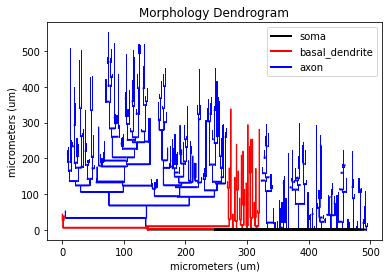

In [19]:
#Display neuron in Tree mode
draw(neuron, mode='dendrogram')

Electrical activity can be appreciated via a dendogram (lengths of different types of trees give us information). 

### Analyzing basic features of a neuron 

In [38]:
?nm.get 
#complete list of morphometrics

In [24]:
#Sum of the lengths of the neuron
total_length = nm.get('total_length', neuron)
print (total_length)

17208.64219111204


In [27]:
#Number of neurites
neurite_num = nm.get('number_of_neurites', neuron)
print (neurite_num)

30


In [29]:
#Number of sections per neurite (bifurcations)
neurite_sec = nm.get('number_of_sections_per_neurite', neuron)
print (neurite_sec)
print(f"Total number of branches : {str(sum(neurite_sec))}")

[243, 5, 7, 3, 13, 19, 1, 1, 1, 9, 3, 1, 25, 1, 3, 3, 1, 1, 13, 12, 1, 13, 3, 1, 5, 1, 1, 5, 3, 3]
Total number of branches : 401


In [25]:
#List of lengths of ALL sections of a neuron
section_length = nm.get('section_lengths', neuron)
print (section_length)

[1.8877224, 3.110539, 20.79115, 17.450642, 13.181905, 4.4145303, 22.977974, 19.713324, 34.881756, 37.667713, 18.377506, 12.1802025, 29.475796, 23.69314, 23.002691, 10.042731, 17.854836, 318.97223, 84.27017, 37.29244, 14.072347, 45.718594, 12.298276, 60.06504, 104.3231, 60.394787, 17.339767, 51.53534, 35.117725, 2.4523683, 85.809296, 79.504486, 132.72852, 160.8466, 7.7402334, 105.07475, 18.396534, 39.089443, 38.865692, 113.56371, 22.110796, 8.005076, 6.3693113, 8.740757, 29.284191, 32.806404, 130.76959, 92.234276, 95.018036, 59.09109, 8.391588, 17.793106, 9.1312065, 12.758755, 2.2245607, 40.881638, 42.191727, 2.0815752, 108.06264, 9.235231, 23.974627, 12.377682, 29.199926, 6.1951694, 10.250216, 54.07847, 9.002126, 57.51904, 23.335682, 74.745255, 61.957504, 44.68535, 64.25603, 14.939381, 84.94834, 24.921757, 41.316387, 9.845378, 35.183605, 8.311474, 14.245695, 15.595948, 208.37088, 10.205502, 22.159294, 25.223347, 149.41809, 8.20651, 24.13328, 7.651808, 6.401772, 14.718345, 17.845814, 33

In [23]:
#Soma features 
print(f"Soma radius : {str(nm.get('soma_radius', neuron))}")
print(f"Soma surface area : {str(nm.get('soma_surface_area', neuron))}")
print(f"Soma volume : {str(nm.get('soma_volume', neuron))}")

Soma radius : 6.5677
Soma surface area : 542.0464015689914
Soma volume : 1186.6660341241275


/usr/local/lib/python3.7/dist-packages/neurom/core/soma.py:84: UserWarning: Approximating soma volume by a sphere. SomaSinglePoint(array([[416.4583, 333.0401,  25.8964,   6.5677]], dtype=float32)) <center: [416.4583 333.0401  25.8964], radius: 6.5677>
  warnings.warn('Approximating soma volume by a sphere. {}'.format(self))


#### Statistical Analysis of Morphometrics of a Single Neuron

In [ ]:
import numpy as np

In [30]:
print (f"Total length: {str(np.sum(section_length))}")
print (f"Mean section length: {str(np.mean(section_length))}")
print (f"Standard deviation of section length: {str(np.std(section_length))}")
print (f"Minimum section length: {str(np.min(section_length))}")
print (f"Maximum section length: {str(np.max(section_length))}")

Total length: 17208.643
Mean section length: 42.91432
Standard deviation of section length: 49.144928
Minimum section length: 0.39820772
Maximum section length: 318.97223


We can perform and obtain statistical properties of neurons using numpy. This gives us a better idea or ability to compare the neuron relative to neuron population distributions. 

**Analysis of statistical properties of each tree-type**

In the given neuron, we only have basal dendrites and axons but no apical dendrites.

In [34]:
#Basal dendrites
section_lengths_basal_dendrites = nm.get('section_lengths',
                                         neuron, 
                                         neurite_type = nm.BASAL_DENDRITE)
print (section_lengths_basal_dendrites)

[1.8877224, 3.110539, 20.79115, 17.450642, 13.181905, 4.4145303, 22.977974, 19.713324, 34.881756, 37.667713, 18.377506, 12.1802025, 29.475796, 23.69314, 23.002691, 10.042731, 17.854836, 318.97223, 84.27017, 37.29244, 14.072347, 45.718594, 12.298276, 60.06504, 104.3231, 60.394787, 17.339767, 51.53534, 35.117725, 2.4523683, 85.809296, 79.504486, 132.72852, 160.8466, 7.7402334, 105.07475, 18.396534, 39.089443, 38.865692, 113.56371, 22.110796, 8.005076, 6.3693113, 8.740757, 29.284191, 32.806404, 130.76959, 92.234276, 95.018036, 59.09109, 8.391588, 17.793106, 9.1312065, 12.758755, 2.2245607, 40.881638, 42.191727, 2.0815752, 108.06264, 9.235231, 23.974627, 12.377682, 29.199926, 6.1951694, 10.250216, 54.07847, 9.002126, 57.51904, 23.335682, 74.745255, 61.957504, 44.68535, 64.25603, 14.939381, 84.94834, 24.921757, 41.316387, 9.845378, 35.183605, 8.311474, 14.245695, 15.595948, 208.37088, 10.205502, 22.159294, 25.223347, 149.41809, 8.20651, 24.13328, 7.651808, 6.401772, 14.718345, 17.845814, 33

In [40]:
print (f"Total length: {str(np.sum(section_lengths_basal_dendrites))}")
print (f"Mean section length: {str(np.mean(section_lengths_basal_dendrites))}")
print (f"Standard deviation of section length: {str(np.std(section_lengths_basal_dendrites))}")
print (f"Minimum section length: {str(np.min(section_lengths_basal_dendrites))}")
print (f"Maximum section length: {str(np.max(section_lengths_basal_dendrites))}")
print (f"Number of sections: {str(nm.get('number_of_sections', neuron, neurite_type = nm.BASAL_DENDRITE))}")

Total length: 12987.918
Mean section length: 47.925896
Standard deviation of section length: 51.794178
Minimum section length: 1.0978304
Maximum section length: 318.97223
Number of sections: 271


In [36]:
#Axons
section_lengths_axons = nm.get('section_lengths',
                                         neuron, 
                                         neurite_type = nm.AXON)
print (section_lengths_axons)


[19.361658, 88.283485, 29.28181, 1.2383599, 9.089329, 11.428228, 17.80273, 43.699455, 21.708822, 31.727097, 3.8118563, 23.419933, 59.32293, 36.1338, 4.7295227, 7.8938227, 39.01148, 10.254884, 39.691357, 21.783737, 5.364902, 23.62333, 0.39820772, 81.36511, 4.631381, 56.58522, 16.857868, 54.517147, 107.842285, 7.3263793, 20.065462, 20.637306, 68.11577, 1.1452851, 214.69614, 71.644356, 40.02877, 5.8213053, 3.5451345, 15.521124, 4.524552, 6.367338, 86.02049, 6.3373666, 12.719835, 12.761745, 35.82797, 7.735676, 0.56057, 28.161545, 33.20577, 123.85216, 0.628012, 55.466763, 56.42207, 5.5848475, 45.909805, 54.784344, 39.1351, 10.230795, 106.25507, 30.702427, 9.388161, 12.859456, 42.394836, 17.235224, 4.5564733, 10.177732, 292.91016, 21.582937, 12.044787, 27.24228, 13.908048, 26.597637, 23.910517, 147.24475, 30.420605, 1.1442845, 8.299021, 5.0227466, 2.162663, 4.366038, 39.91496, 1.1882262, 0.9795971, 49.177456, 5.957268, 3.3394024, 59.531986, 12.550073, 30.783325, 32.890556, 20.340605, 0.65556

In [41]:
print (f"Total length: {str(np.sum(section_lengths_axons))}")
print (f"Mean section length: {str(np.mean(section_lengths_axons))}")
print (f"Standard deviation of section length: {str(np.std(section_lengths_axons))}")
print (f"Minimum section length: {str(np.min(section_lengths_axons))}")
print (f"Maximum section length: {str(np.max(section_lengths_axons))}")
print (f"Number of sections: {str(nm.get('number_of_sections', neuron, neurite_type = nm.AXON))}")

Total length: 4220.7246
Mean section length: 32.467113
Standard deviation of section length: 41.18579
Minimum section length: 0.39820772
Maximum section length: 292.91016
Number of sections: 130


Observing the statistical properties of basal dendrites and axons, we can now compare them and see that for this neuron, the mean section lengths of axons are smaller than its basal dendrites. The total length of basal dendrites are also much larger than the total length of its axons. We can also see that basal dendrites have much more basal dendrites than axons. 

**Plotting Basic Morphometrics**

Text(0.5, 0, 'Distribution of Neuron Section Lengths')

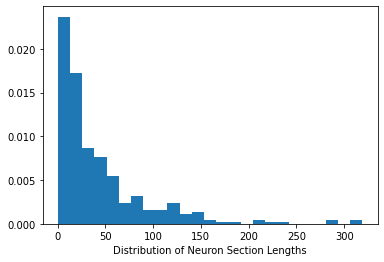

In [53]:
#Distribution of section lengths
histogram = plt.hist(section_length, bins = 25, density = True)
plt.xlabel('Distribution of Neuron Section Lengths')

Text(0.5, 0, 'Boxplot of section lengths')

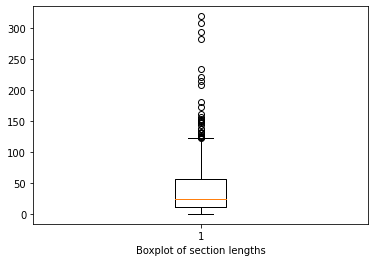

In [55]:
boxplot = plt.boxplot(section_length)
plt.xlabel("Boxplot of section lengths")

From the distribution and the boxplot shown above, we can see that most of the neurite sections are between 0-50 μm in length (at least 50%) and there are outlier neurites with more than 150-300μm in length. These information are not as straightforward as simply obtaining the basic statistics of our neuron. 

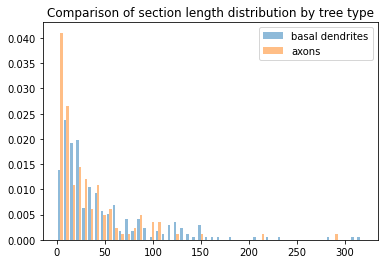

In [58]:
#Comparing the distribution of different tree types for the same neuron
plt.hist([section_lengths_basal_dendrites, section_lengths_axons], 
          label=['basal dendrites', 'axons'], bins=50, density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.title("Comparison of section length distribution by tree type")
plt.show()

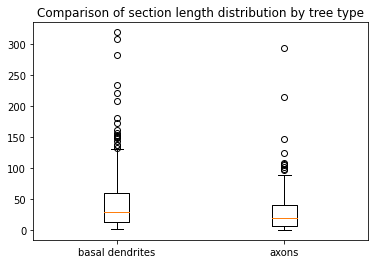

In [61]:
plt.boxplot([section_lengths_basal_dendrites, section_lengths_axons], 
          labels=['basal dendrites', 'axons'])
plt.title("Comparison of section length distribution by tree type")
plt.show()

If we compare the two distributions above, we see that compared to basal dendrites, more axons have shorter lengths which is likely why the average is smaller. However, both have extreme outliers although there are more basal dendrite outliers than axonal outliers. These observations are not prominent when simply comparing basic statistics.

### Generate Distributions of Neuron Morphologies and Observe Characteristics

Steps:
1. Generate Distributions of the Properties of 50 Neurons

*   List item
*   List item


2. Compare Two Neurons 
3. Compare The Neurons Relative to the Distribution of All Neurons